#1. Point map

senario 1: (the most basic point map). Let's say we want to plot all postal codes of Brazil on the map of the brazil,and we have a dataset contain all postal codes and its relative geo lacation(longtitude and latitude)

link of this dataset https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_geolocation_dataset.csv

In [1]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "olist_geolocation_dataset.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "olistbr/brazilian-ecommerce",
  file_path,
  pandas_kwargs={"dtype": {"geolocation_zip_code_prefix": str}} # this is important,or Panda would automatically percieve thrm as integer,and miss the zeros.
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

/tmp/ipython-input-1375910622.py:10: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:   geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                       01037       -23.545621       -46.639292   
1                       01046       -23.546081       -46.644820   
2                       01046       -23.546129       -46.642951   
3                       01041       -23.544392       -46.639499   
4                       01035       -23.541578       -46.641607   

  geolocation_city geolocation_state  
0        sao paulo                SP  
1        sao paulo                SP  
2        sao paulo                SP  
3        sao paulo                SP  
4        sao paulo                SP  


We use geopanda to plot our map

In [2]:
%pip install folium geopanda

ERROR: Could not find a version that satisfies the requirement geopanda (from versions: none)
ERROR: No matching distribution found for geopanda


Ensure the data is in the correct format for plotting on a map. This might involve handling missing values or converting data types if necessary.

In [3]:
print("Missing values in geolocation_lat:", df['geolocation_lat'].isnull().sum())
print("Missing values in geolocation_lng:", df['geolocation_lng'].isnull().sum())

print("\nData type of geolocation_lat:", df['geolocation_lat'].dtype)
print("Data type of geolocation_lng:", df['geolocation_lng'].dtype)

Missing values in geolocation_lat: 0
Missing values in geolocation_lng: 0

Data type of geolocation_lat: float64
Data type of geolocation_lng: float64


Generate a base map of Brazil.

In [4]:
import folium

brazil_map = folium.Map(location=[-14.235004, -51.92528], zoom_start=4)

Overlay the geolocation data points onto the base map.

In [5]:
# Limit the number of points to plot for performance reasons
sample_df = df.sample(n=10000, random_state=42)

for index, row in sample_df.iterrows():
    folium.CircleMarker(
        location=[row['geolocation_lat'], row['geolocation_lng']],
        radius=1,
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(brazil_map)

brazil_map

we limited the number of points to plot  because plotting too many points (e.g., 100k+) on a Folium map slows it down or crashes the browser.

Rainbow colormap map each categorical value to a colour,




senario 2: we want to know if there's and relation between the "value" of the postocode and the location.

In [6]:
#%pip install geobr

So we may want "rainbow colour map" here

#What is rainbow clolormap?

It is rainbow colormap is a color gradient that spans the full range of visible colors, typically in the order of:

🔵 Blue → 🟢 Green → 🟡 Yellow → 🟠 Orange → 🔴 Red (and sometimes ending in purple/violet).

And it map each data point to a colour



Fetching shapefile for São Paulo municipality...
Shapefile loaded using geobr.
Shapefile loaded.


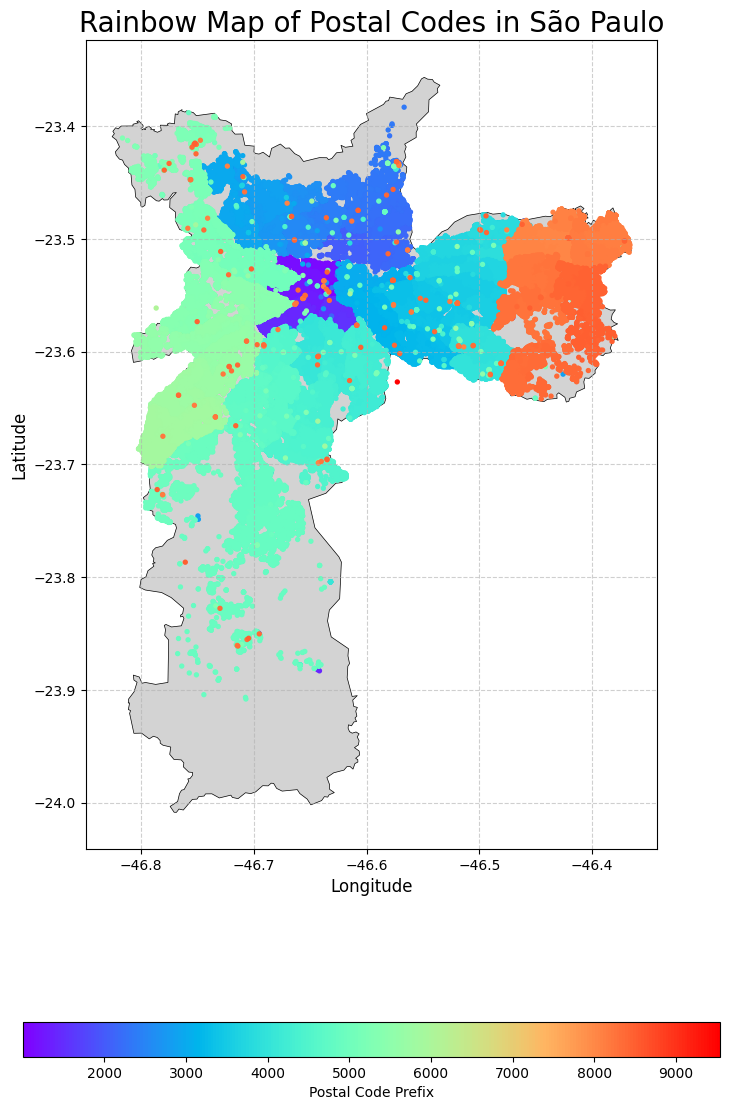

In [7]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geobr import read_municipality

# Filter the DataFrame to include only data for the city of 'sao paulo'
sao_paulo_geo_df = df[df['geolocation_city'] == 'sao paulo'].copy()

# Convert the zip code prefix to a numeric type for color mapping
# We use .copy() above to avoid SettingWithCopyWarning
sao_paulo_geo_df['zip_code_numeric'] = pd.to_numeric(sao_paulo_geo_df['geolocation_zip_code_prefix'])

# Create a GeoDataFrame from the pandas DataFrame
# This object understands spatial data (latitude and longitude)
gdf_points = gpd.GeoDataFrame(
    sao_paulo_geo_df,
    geometry=gpd.points_from_xy(sao_paulo_geo_df.geolocation_lng, sao_paulo_geo_df.geolocation_lat)
)


# --- 2. Get the Map of São Paulo ---

print("Fetching shapefile for São Paulo municipality...")
try:
    # Use geobr to read the municipality shapefile for São Paulo
    # The code for São Paulo is 3550308
    sao_paulo_shape = read_municipality(code_muni=3550308, year=2020)
    print("Shapefile loaded using geobr.")
except Exception as e:
    print(f"Could not load shapefile using geobr: {e}")
    sao_paulo_shape = gpd.GeoDataFrame() # Create an empty GeoDataFrame if loading fails


if sao_paulo_shape.empty:
    print("Could not find 'Sao Paulo' shapefile.")
else:
    print("Shapefile loaded.")


    # --- 3. Plot the Data ---

    # Create a plot figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))

    # Plot the shape of São Paulo as the base layer
    sao_paulo_shape.plot(
        ax=ax,
        color='lightgray',
        edgecolor='black',
        linewidth=0.5
    )

    # Plot the geolocation points on top of the map
    # - `column` specifies which data to use for coloring
    # - `cmap='rainbow'` sets the color scheme
    # - `markersize` controls the size of the points
    # - `legend=True` displays a color bar
    # - `legend_kwds` customizes the legend
    gdf_points.plot(
        ax=ax,
        column='zip_code_numeric',
        cmap='rainbow',
        markersize=8,
        legend=True,
        legend_kwds={
            'label': "Postal Code Prefix",
            'orientation': "horizontal",
            'shrink': 0.6  # Shrink the legend to fit better
        }
    )

    # --- 4. Final Touches ---

    ax.set_title('Rainbow Map of Postal Codes in São Paulo', fontsize=20)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)

    # Display the final plot
    plt.show()

Remark:


column='zip_code_numeric': You tell GeoPandas to color points based on this column's values.

cmap='rainbow': The rainbow colormap is applied across the range of values in zip_code_numeric.

The lowest value gets the start of the colormap (e.g., blue), the highest gets the end (e.g., red), and everything in between is interpolated.








Bonus: Behind the scenes The values in 'zip_code_numeric' are normalized to the 0–1 range internally.

Then they're mapped to a color in the 'rainbow' colormap using that normalized value.